# Taking short walks up and down slopes in Julia

In [1]:
using DynLoco
using Plots
default(grid=false) # no grid on plots

┌ Info: Precompiling DynLoco [086b9634-299f-4133-910a-656d08a98501]
└ @ Base loading.jl:1664


## Short walks of different distances
Take walks of varying distances, and show how the optimal trajectory is to have a bell-shaped
velocity profile, with peak speed that increases with distance up to about 12 steps.
The cost function is total work, plus a linear cost of time with coefficient ctime.

times [0.0, 2.373933502400896, 4.745692943614067, 5.745692943614067]
v = [0.0, 0.2888857730080973, 0.28915057867762245, 0.0]
1.8946120201619077 6.301248499169622 1.3825875613161003
times [0.0, 2.2292011984810816, 4.203047329876239, 6.430122016658431, 7.430122016658431]
v = [0.0, 0.30764186533641985, 0.3474412741717448, 0.30793561571200845, 0.0]
2.1241320988278085 7.985677572213986 1.950954938302793
times [0.0, 2.1628500160650823, 4.012811036935396, 5.862282167141573, 8.023083371159839, 9.023083371159839]
v = [0.0, 0.3170795985930568, 0.3707081431306429, 0.3708063368550398, 0.31738024471459225, 0.0]
2.152273401767209 9.578638926715396 2.202475152171437
times [0.0, 2.128487527505477, 3.9219157781074667, 5.647937320351801, 7.440687911519929, 9.567177074444245, 10.567177074444245]
v = [0.0, 0.3221985593284798, 0.3823936723873429, 0.39732737867174445, 0.38253821713373354, 0.3225013448776794, 0.0]
2.5586138499999476 11.122732629999803 2.4462794211110808
times [0.0, 2.1097349421271043, 3.8740

┌ Info: Precompiling GR_jll [d2c73de3-f751-5644-a686-071e5b155ba9]
└ @ Base loading.jl:1664


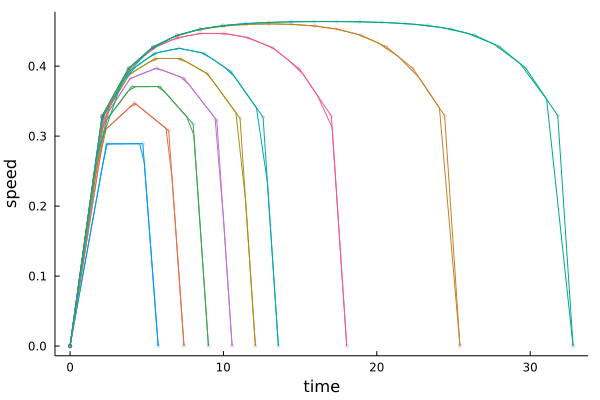

In [2]:
wstar4 = findgait(WalkRW2l(α=0.35), target=:speed=>0.3, varying=:P)
ctime = 0.02 # cost of time, to encourage hurrying
tchange = 1
p = plot()
walksteps = [2, 3, 4, 5, 6, 7, 10, 15, 20] # take walks of this # of steps
results = Array{MultiStepResults,1}(undef,0) # store each optimization result here
for (i,nsteps) in enumerate(walksteps)
    result = optwalktime(wstar4, nsteps, ctime=ctime) # optimize with a cost of time
    plotvees!(result, tchange=tchange, color=i, rampuporder=1, markersize=2) # plot instantaneous speed vs. time
    push!(results, result) # add this optimization to results array
end
Plots.display(p) # instantaneous speed vs. distance profiles

## Short walks: Peak speed vs. distances

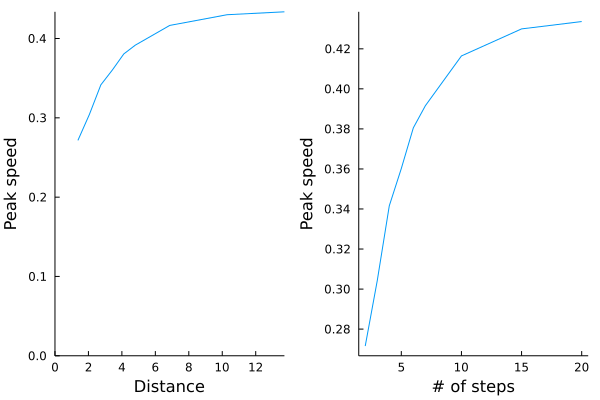

In [3]:
peakspeeds = [maximum(result.steps.vm) for result in results]
distances = [sum(result.steps.steplength) for result in results]
p1 = plot(distances, peakspeeds, xlabel="Distance", ylabel="Peak speed", xlims=(0,Inf), ylims=(0,Inf))
p2 = plot(walksteps, peakspeeds, xlabel="# of steps", ylabel="Peak speed")
plot(p1, p2, layout = (1,2), legend=false)

## Short walks: Time to walk a distance
A fairly linear increase in time to walk a distance, but with a slight curved toe-in

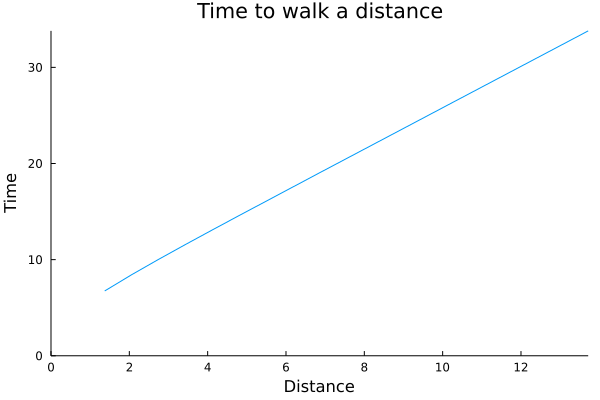

In [4]:
timetowalk = [result.totaltime+2*tchange for result in results]
plot(distances, timetowalk, xlims=(0,Inf), ylims=(0,Inf),
    xguide="Distance", yguide="Time", title="Time to walk a distance", label=nothing)

## Short walks: Up and down slopes
Compare walking uphill, downhill, and level, for a fixed number of steps, and including
optimized time. The results show uphill walking is skewed to fast speed-up at beginning,
slow coasting toward end. Downhill is skewed for slow speed-up aided by gravity, and
abrupt end.
`optwalktime` is an optimization for a given number of steps, with a `ctime` cost.

Make plots comparing up, level, down for various numbers of steps

times [0.0, 2.431773534883629, 4.426445229009959, 6.348628556746721, 8.342024438704966, 10.768186154778231, 11.768186154778231]
v = [0.0, 0.32027517095853736, 0.3904585836911036, 0.4051833523779063, 0.3907084847853695, 0.32101598152238836, 0.0]
2.87466887114047 12.323741710333788 3.2552906524679326
times [0.0, 1.9157032615400191, 3.688781641168492, 5.457241990600273, 7.349600465671101, 9.965753238263876, 10.965753238263876]
v = [0.0, 0.4065539273505231, 0.43925677148039943, 0.440403815029015, 0.41156931674277525, 0.29770305953708665, 0.0]
1.5092124996089162 11.521308793819433 3.6635023141630096
times [0.0, 2.62571653515313, 4.5191371097402895, 6.286823061207662, 8.057785774781902, 9.968632493043145, 10.968632493043145]
v = [0.0, 0.29661872261922584, 0.41133845014181186, 0.44059674964932627, 0.43978152597319026, 0.40758721103804474, 0.0]
3.7077417956825625 11.301965826376478 1.2439631136689364
times [0.0, 2.417359504196837, 4.381383532843544, 6.2298075620875375, 8.035523237331502, 9.826

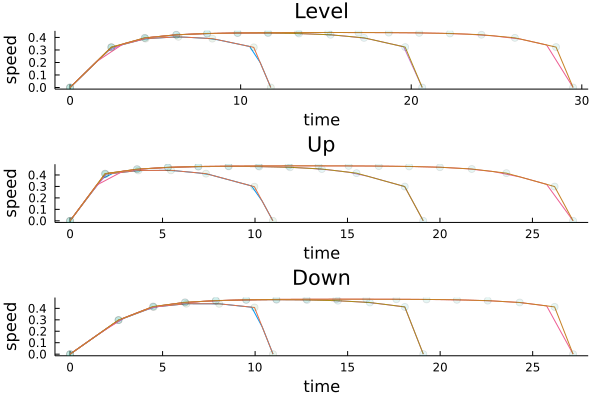

In [5]:
wstar4s = findgait(WalkRW2l(α=0.4,safety=true), target=:speed=>0.4, varying=:P)
myslope = 0.08
p = plot(layout=(3,1))
for (i,nsteps) = enumerate([5, 10, 15])
    resultlevel = optwalktime(wstar4s, nsteps, ctime = ctime)
    plotvees!(p[1],resultlevel, tchange=tchange, title="Level", rampuporder=1) # special function to include ramp-up in speed

    # walk up a 10% slope
    resultup = optwalktime(wstar4s, nsteps, ctime = ctime, δs=fill(myslope, nsteps))
    plotvees!(p[2],resultup, tchange=tchange, title="Up", rampuporder=1)

    # Walk down a slope
    resultdown = optwalktime(wstar4s, nsteps, ctime = ctime, δs=fill(-myslope, nsteps))
    plotvees!(p[3],resultdown, tchange=1, title="Down", rampuporder=1)
end
Plots.display(p)

## Short walks: Varying slope angles
The steeper, the more skewed the speed profile

Make plots comparing up, level, down for various numbers of steps

times [0.0, 2.4236797365508718, 4.400969207946737, 6.280442036048411, 8.159574472860832, 10.135457004879202, 12.553536163498048, 13.553536163498048]
v = [0.0, 0.3213447193009338, 0.3938910796240077, 0.4143910318745871, 0.4144660958215612, 0.3941715522034182, 0.32208899441578054, 0.0]
3.34449782080358 14.109091719053605 2.9178098035932596
times [0.0, 2.4236797365508718, 4.400969207946737, 6.280442036048411, 8.159574472860832, 10.135457004879202, 12.553536163498048, 13.553536163498048]
v = [0.0, 0.3213447193009338, 0.3938910796240077, 0.4143910318745871, 0.4144660958215612, 0.3941715522034182, 0.32208899441578054, 0.0]
3.34449782080358 14.109091719053605 2.9178098035932596
times [0.0, 2.3149974337571146, 4.264558587398649, 6.129747894796241, 8.00184567526593, 9.982474262812431, 12.482899012950995, 13.482899012950995]
v = [0.0, 0.3364309062551709, 0.3994933337497684, 0.4175644163990914, 0.4160235072881181, 0.39322702374102503, 0.3114817530798081, 0.0]
2.6162828331358816 14.038454568506552

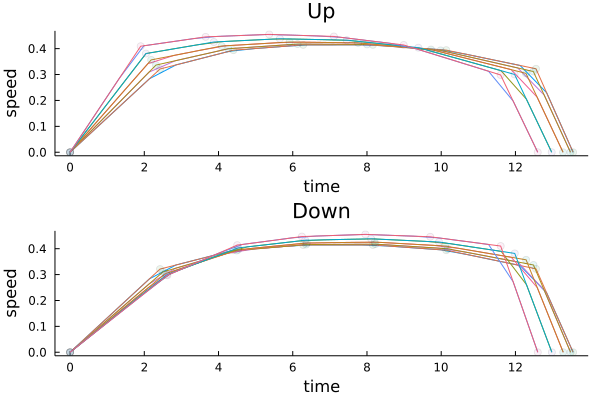

In [6]:
wstar4s = findgait(WalkRW2l(α=0.4,safety=true), target=:speed=>0.4, varying=:P)
myslopes = 0:0.02:0.08
p = plot(layout=(2,1))
nsteps = 6
startv = wstar4.vm
for slope in myslopes
    # walk up a slope
    resultup = optwalktime(wstar4s, nsteps, ctime = ctime, δs=fill(slope, nsteps))
    plotvees!(p[1],resultup, tchange=1, title="Up", rampuporder=1)
    startv = [resultup.vm0;resultup.steps.vm]

    # Walk down a slope
    resultdown = optwalktime(wstar4s, nsteps, ctime = ctime, δs=fill(-slope, nsteps))
    plotvees!(p[2],resultdown, tchange=1, title="Down", rampuporder=1)
end
Plots.display(p)

## Short walks: Varying step lengths
Shorter steps will yield a more plateaued speed profile.
Longer steps will reach more of a rounded profile with bigger range of speeds.
(This optimization allows for faster speeds at short steps, due to a lack of
swing leg cost. Humans will probably not walk faster with short steps.)

times [0.0, 1.1113425936902672, 2.1488930046538495, 3.140876063497857, 4.106051451876192, 5.058734440182207, 6.011415740498968, 6.976586115058629, 7.968561114536518, 9.006101583008874, 10.117436907398693, 11.117436907398693]
v = [0.0, 0.35753030959673743, 0.38295841569867484, 0.40054984613664174, 0.41167508659511265, 0.41707332498572086, 0.4170740639687265, 0.4116772251442139, 0.40055310043020764, 0.3829620854935446, 0.35753264822053804, 0.0]
1.5331625526302028 11.67299246295425 2.5331625526302037
times [0.0, 1.7721532755707003, 3.3064750221366634, 4.749645915051394, 6.167400428850833, 7.61044325717079, 9.144474603067524, 10.916164472291292, 11.916164472291292]
v = [0.0, 0.33351540268566315, 0.38521282426291237, 0.40954291430377443, 0.416884875040003, 0.40957925968891024, 0.3852857471938947, 0.3336026375663773, 0.0]
2.2864439824706815 12.47172002784685 2.659277431297456
times [0.0, 2.431773533382891, 4.4264452248753265, 6.348628537045872, 8.342024382361988, 10.768186067857648, 11.76818

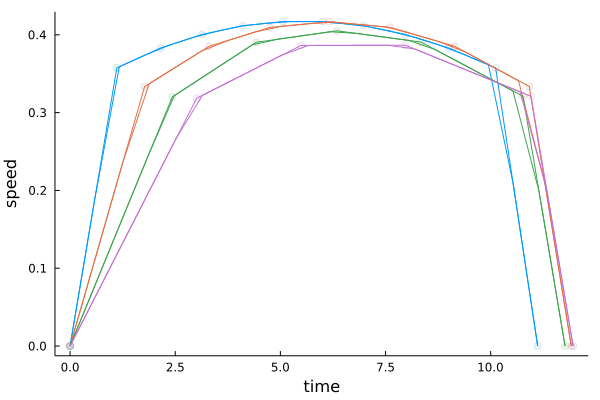

In [7]:
stepfreq = onestep(wstar4).stepfrequency
αs = [0.2, 0.3, 0.4, 0.5]
nominalsteps = 6
totaldistance = 6*onestep(wstar4).steplength # walk a similar distance for all
steplengths = 2*wstar4.L .* sin.(αs)
p = plot()
results = Array{MultiStepResults,1}(undef,0) # store each optimization result here
for (i,α) in enumerate(αs)
    nsteps = Int(round(totaldistance/steplengths[i]))
    w = findgait(WalkRW2l(wstar4,α=α,safety=true), target=:stepfrequency=>stepfreq, varying=:P)
    result = optwalktime(w, nsteps, ctime=ctime) # optimize with a cost of time
    plotvees!(result, tchange=1, color=i, rampuporder=1) # plot instantaneous speed vs. time
    push!(results, result) # add this optimization to results array
end
Plots.display(p) # instantaneous speed vs. distance profiles

## Short walks: Compare trapezoid cruising against short walk
Another way to walk a short distance with cruise speed, "trapezoid" velocity
Start from a boundaryvel, do boundary work to get a certain speed
then continue with a ramp up in speed, then stay at a cruise speed
and then ramp down and hit another boundaryvel
v[1] is the mid-stance velocity where you have say Naccel steps to get to cruise
 speed up    cruise cruise cruise cruise   slow down
0 v[1] v[2]  v[Naccel+1] to v[Naccel + N]  v[end-2] v[end-1] v[end]

trapezoid cost = 0.20868784294084677   optimal cost = 0.18726183810087355


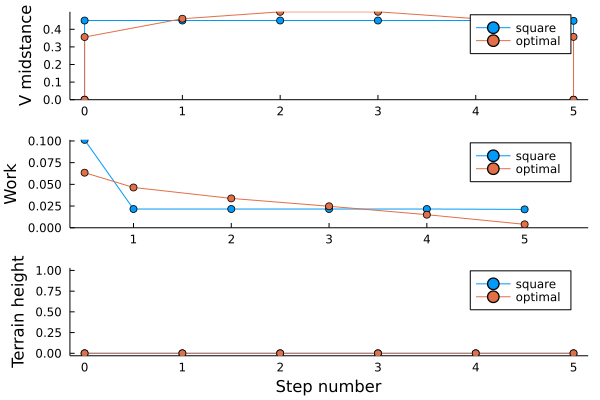

In [8]:
using JuMP, Ipopt
boundaryvels = (0.,0.) # actually the code below all assumes 0 boundary speed

Ncruise = 5 # how many steps of cruising
Naccel = 0  # how many steps of start-up (and again for end)
Nsteps = Naccel*2 + Ncruise
vcruise = 0.45 # cruising speed, always fixed
# linear increase deltavel = vcruise/(Naccel+1)
# constraint v[i=1..Naccel] = deltavel*i
deltavel = vcruise / (Naccel+1) # assuming starting from zero speed
velstart = [deltavel*i for i in 1:Naccel] # ramp up in speed
velcruise = [vcruise for i in 1:Ncruise]
velend = [deltavel*(Naccel+1-i) for i in 1:Naccel]
vels = [velstart; velcruise; velend]
# constraint v[Naccel+1 ... Naccel+N] == vcruise
# constraint v[Naccel+N+(1..Naccel)] == deltavel*(Naccel+1-i)
# solve for P that produces it, time will be an outcome
w = WalkRW2l(wstar4, safety=true)
optsteps = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level"=>0))
@variable(optsteps, P[1:Nsteps]>=0, start=w.P) # JuMP variables P

# Constraints
register(optsteps, :onestepv, 3, # velocity after a step
    (v,P,δ)->onestep(w,P=P,vm=v, δangle=δ).vm, autodiff=true) # output vm
for i = 1:Nsteps-1  # step dynamics
    @NLconstraint(optsteps, vels[i+1]==onestepv(vels[i],P[i],0.)) # put delta here
end

# leave out the objective, because we are fully prescribing everything with constraints
optimize!(optsteps)
if termination_status(optsteps) == MOI.LOCALLY_SOLVED || termination_status(optsteps) == MOI.OPTIMAL
    optimal_solution = Ps=value.(P)
else
    error("The model was not solved correctly.")
    println(termination_status(optsteps))
end
trapezoidresults=multistep(WalkRW2l(w,vm=vels[1]), Ps=optimal_solution, boundaryvels=(0.,0.),
    extracost = 1/2*(vels[1]^2 - boundaryvels[1]^2) )

# verify with multistep
multistepplot(trapezoidresults,plotwork=true, label="square")

# If you just want to do square wave in speed, it costs a lot of initial push-off
# so let's compare with walking the same number of steps and same amount of time
optresults=optwalk(w, Ncruise, boundaryvels=(0,0),totaltime=trapezoidresults.totaltime  )
println("trapezoid cost = ", trapezoidresults.totalcost, "   optimal cost = ", optresults.totalcost)
# It's definitely more expensive to use the square wave
multistepplot!(optresults,plotwork=true,label="optimal")

#### Trajectory for short walks
To be continued

## Brachistokuo Ramp

Optimal slope and walk with ramp
Compare walking ramp and flat in same amount of time, for three different times

ramp total cost = 0.24969756338511045
flat total cost = 0.26745283887450116


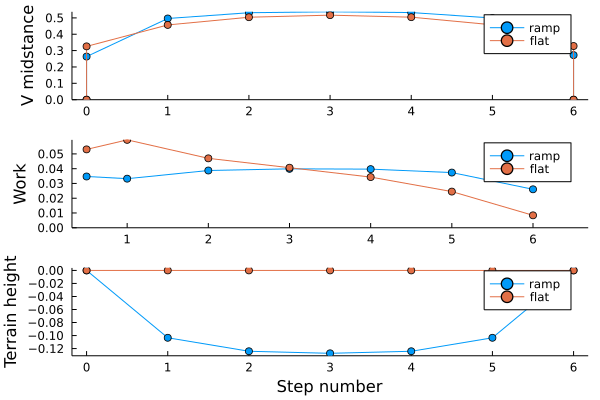

In [10]:
wstar = findgait(WalkRW2l(α=0.4,safety=true), target=:speed=>0.4, varying=:P)
N = 6
walktime = N * onestep(wstar).tf *0.82 # meant to be a brisk walk
walkdistance = N * onestep(wstar).steplength
rampresult = optwalkslope(wstar, N, boundaryvels = (0., 0.), symmetric = true,
    totaltime = walktime)
p = multistepplot(rampresult; plotwork=true, label="ramp")
println("ramp total cost = ", rampresult.totalcost)
flatresult = optwalk(wstar, N, boundaryvels = (0., 0.),
    totaltime = rampresult.totaltime, δs = zeros(6))
println("flat total cost = ", flatresult.totalcost)
multistepplot!(flatresult; plotwork=true, label="flat")
# optionally, try a reversed ramp and see if it's higher cost still
#concaveresult = optwalk(wstar, 6, boundaryvels = (0.,0.), boundarywork=true,
#    totaltime = rampresult.totaltime, δ = -rampresult.δangles)
#multistepplot!(concaveresult; plotwork=true)

## Brachistokuo ramp: Compute the cost for different speeds

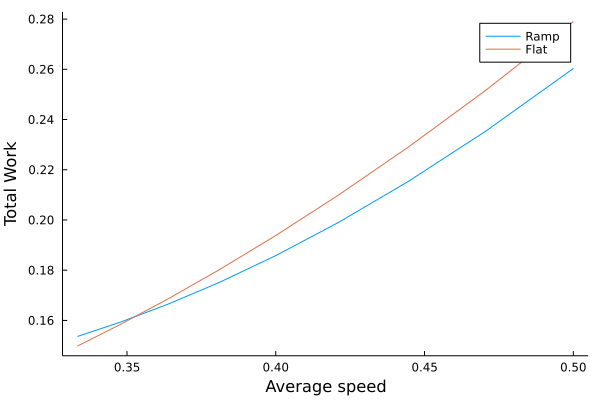

In [11]:
walktimes = (0.8:0.05:1.2) * N*onestep(wstar).tf
rampresults = Array{MultiStepResults,1}(undef, length(walktimes))
flatresults = Array{MultiStepResults,1}(undef, length(walktimes))
for (i,walktime) in enumerate(walktimes)
    rampresults[i] = optwalk(wstar, N, boundaryvels = (0.,0.),
        totaltime = walktime, δs = rampresult.δangles)
    flatresults[i] = optwalk(wstar, N, boundaryvels = (0.,0.),
        totaltime = walktime, δs = zeros(N))
end
# plot totalcost vs average speed
plot(walkdistance ./ walktimes, [getfield.(rampresults, :totalcost), getfield.(flatresults, :totalcost)],
    xlabel="Average speed", ylabel="Total Work", labels=["Ramp" "Flat"])

## Brachistokuo ramp: Plot the ramp to scale

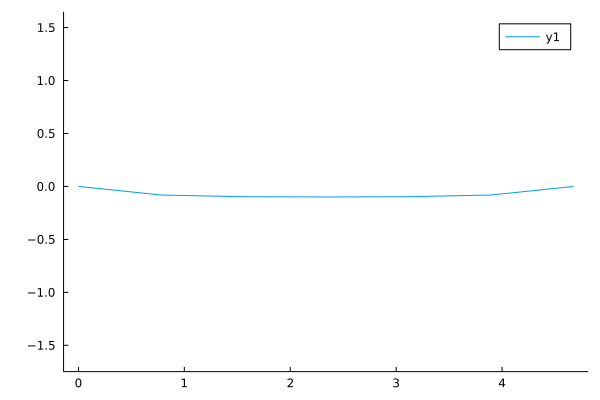

In [12]:
plot(onestep(wstar).steplength .* (0:6),cumsum(tan.([0;rampresult.δangles]).*onestep(wstar).steplength),
    aspect_ratio=1)